<a href="https://colab.research.google.com/github/keysenelvial/dinam/blob/main/dinam2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Лабораторная работа №2**

Выберите временной ряд с ценами актива (предпочтительно с явной сезонностью, например, акции компании с сезонным бизнесом).
Проведите декомпозицию временного ряда на тренд, сезонность и остаток. Визуализируйте компоненты декомпозиции. Проанализируйте сезонность: определите периодичность и амплитуду сезонных колебаний. Удалите сезонность из ряда и сравните исходный ряд с десезонализированным. Постройте прогноз на основе выявленных тренда и сезонности на 12 периодов вперед. Оцените качество прогноза, используя метрики MAE и RMSE. Сделайте выводы о влиянии сезонности на цены актива и эффективности прогнозирования. Проведите тест на стационарность ряда (тест Дики-Фуллера). Если ряд нестационарен, приведите его к стационарному виду. Постройте и сравните модели AR, MA, ARMA и ARIMA. Подберите оптимальные параметры для каждой модели, используя информационные критерии (AIC, BIC). Проведите диагностику остатков моделей. Сделайте прогноз на 30 дней вперед для каждой модели. Сравните качество прогнозов моделей, используя метрики MAE, RMSE и MAPE. Визуализируйте результаты прогнозирования.

In [21]:
!pip install pmdarima

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [22]:

file_path = "/content/drive/MyDrive/season.csv"
data = pd.read_csv(file_path)

data['DATETIME'] = pd.to_datetime(data['DATETIME'])
data.set_index('DATETIME', inplace=True)


ts = data['CLOSE']


print(ts.head())


DATETIME
2022-01-01 00:00:00    50.668730
2022-01-01 00:01:00    50.034751
2022-01-01 00:02:00    50.821704
2022-01-01 00:03:00    51.698046
2022-01-01 00:04:00    49.941862
Name: CLOSE, dtype: float64


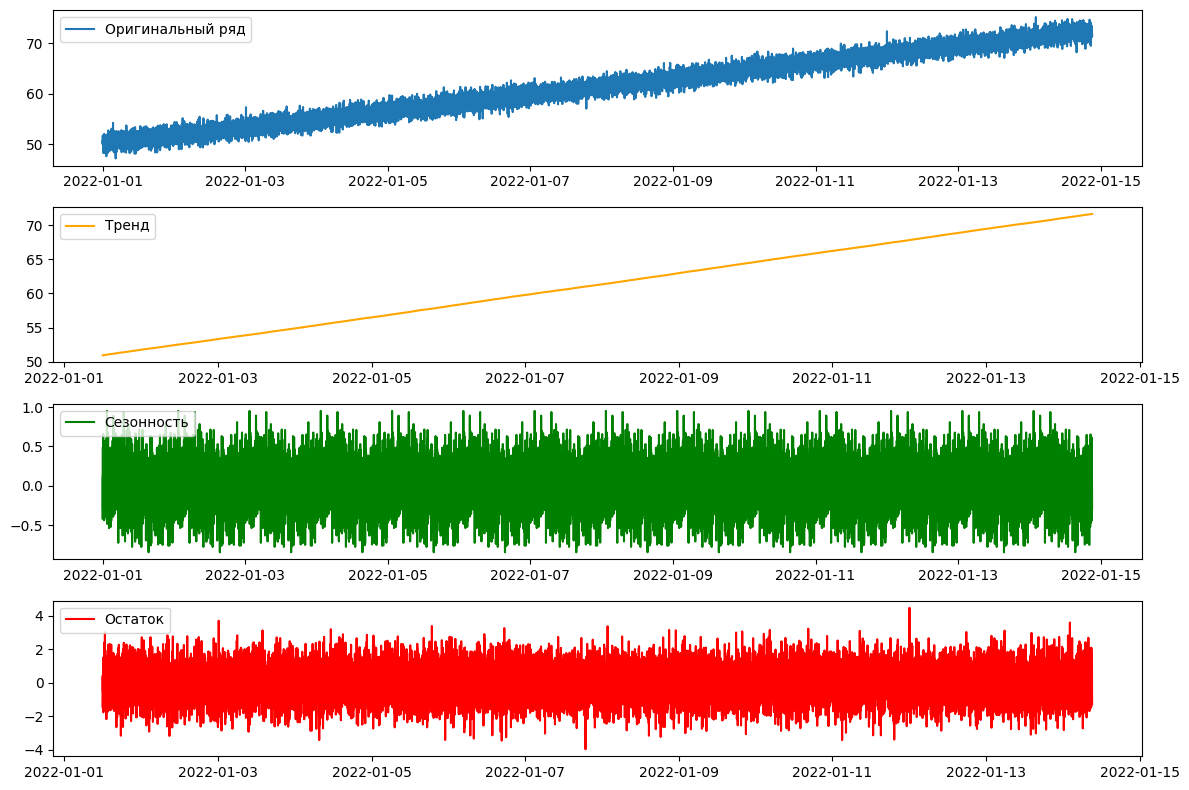

In [23]:
train = ts[:-12]  # Все данные, кроме последних 12 периодов
test = ts[-12:]   # Последние 12 периодов для проверки
#Декомпозиция временного ряда
decomposition = seasonal_decompose(train, model='additive', period=1440)
trend = decomposition.trend
seasonal = decomposition.seasonal

# Визуализация компонентов
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(train, label='Оригинальный ряд')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Тренд', color='orange')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Сезонность', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Остаток', color='red')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

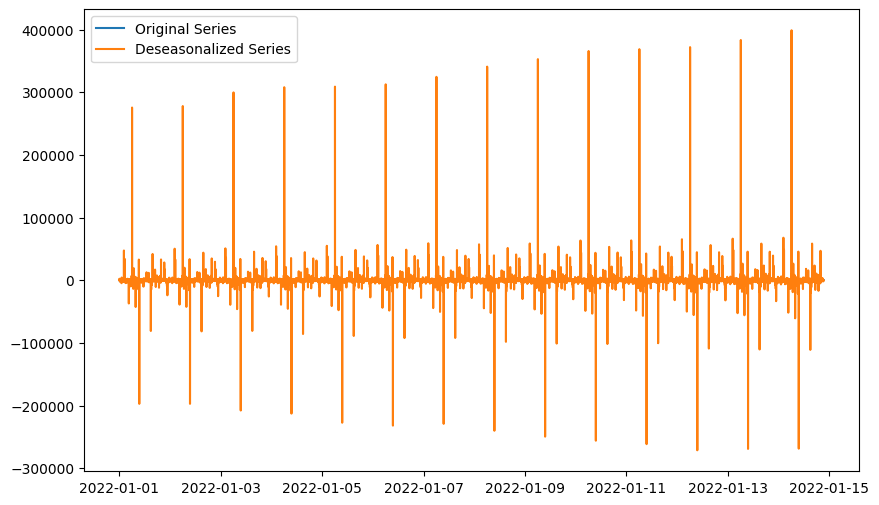

In [24]:
# Десезонирование ряда
deseasonalized = ts / seasonal

# Сравнение исходного ряда и десезонированного
plt.figure(figsize=(10, 6))
plt.plot(ts, label='Original Series')
plt.plot(deseasonalized, label='Deseasonalized Series')
plt.legend(loc='best')
plt.show()

MAE: 1.403
RMSE: 1.599


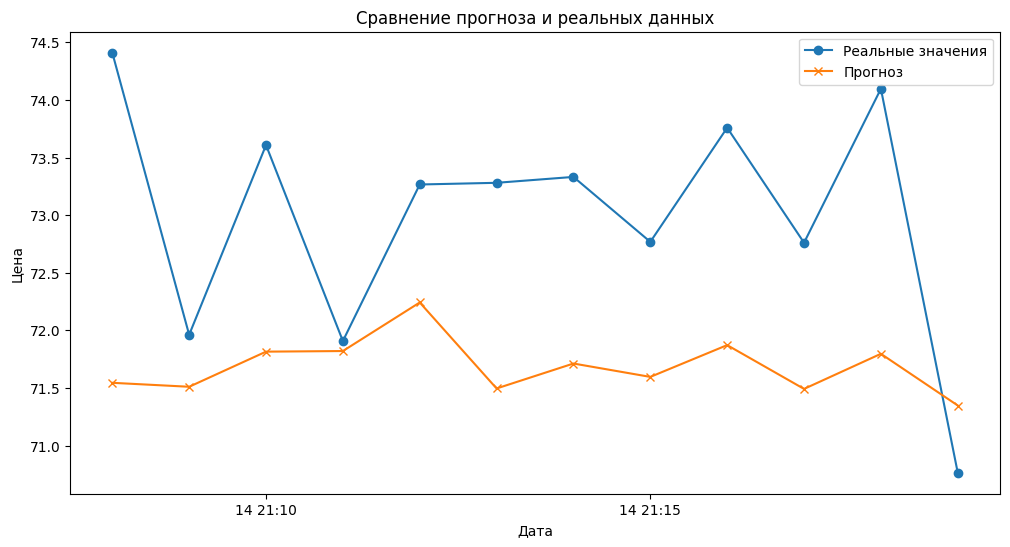

In [25]:
# Прогноз на основе тренда и сезонности
# Убедимся, что длины тренда и сезонности корректны для последних 12 периодов
last_trend = trend.dropna().iloc[-12:]  # Берем последние 12 значений тренда
last_seasonal = seasonal[-12:]          # Берем последние 12 значений сезонности

# Убедимся, что длины совпадают
assert len(last_trend) == len(test), "Длина тренда и тестовой выборки не совпадает"
assert len(last_seasonal) == len(test), "Длина сезонности и тестовой выборки не совпадает"

# Прогнозируем значения: сумма последнего тренда и сезонности
forecast = last_trend.values + last_seasonal.values

# Оценка качества прогноза
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

# Визуализация прогноза и тестовых данных
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Реальные значения', marker='o')
plt.plot(test.index, forecast, label='Прогноз', marker='x')
plt.title('Сравнение прогноза и реальных данных')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()

In [26]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")



# Шаг 2: Тест на стационарность (тест Дики-Фуллера)
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= 0.05:
        print("Ряд стационарен.")
    else:
        print("Ряд нестационарен.")

print("Тест на стационарность для исходного ряда:")
adf_test(ts)

# Приведение ряда к стационарному виду, если необходимо
ts_diff = ts.diff().dropna()

print("\nТест на стационарность для дифференцированного ряда:")
adf_test(ts_diff)

# Шаг 3: Построение моделей AR, MA, ARMA и ARIMA
# Оптимизация параметров моделей с использованием AIC и BIC
def evaluate_model(X, model_type, p_values, q_values, d=0):
    best_aic, best_bic, best_order, best_model = float('inf'), float('inf'), None, None
    print(f"\nТестирование модели {model_type}...")
    for p in p_values:
        for q in q_values:
            try:
                print(f"Тестируем параметры: p={p}, d={d}, q={q}")
                if model_type == 'AR':
                    model = ARIMA(X, order=(p, 0, 0))
                elif model_type == 'MA':
                    model = ARIMA(X, order=(0, 0, q))
                elif model_type == 'ARMA':
                    model = ARIMA(X, order=(p, 0, q))
                elif model_type == 'ARIMA':
                    model = ARIMA(X, order=(p, d, q))
                fitted_model = model.fit()
                aic = fitted_model.aic
                bic = fitted_model.bic
                print(f"Результат: AIC={aic:.3f}, BIC={bic:.3f}")
                if aic < best_aic:
                    best_aic, best_bic, best_order, best_model = aic, bic, (p, d, q), fitted_model
            except Exception as e:
                print(f"Ошибка для параметров p={p}, d={d}, q={q}: {e}")
                continue
    print(f"Лучшие параметры для {model_type}: order={best_order}, AIC={best_aic:.3f}, BIC={best_bic:.3f}")
    return best_aic, best_bic, best_order, best_model

# Диапазон значений для p и q
p_values = range(0, 4)
q_values = range(0, 4)

# AR
ar_aic, ar_bic, ar_order, ar_model = evaluate_model(ts_diff, 'AR', p_values, [0])
print(f"Лучший AR: order={ar_order}, AIC={ar_aic}, BIC={ar_bic}")


Тест на стационарность для исходного ряда:
ADF Statistic: -0.5122751774226914
p-value: 0.889598736173296
Critical Values:
	1%: -3.4306777773505996
	5%: -2.86168486605018
	10%: -2.566847108243414
Ряд нестационарен.

Тест на стационарность для дифференцированного ряда:
ADF Statistic: -34.81972037910816
p-value: 0.0
Critical Values:
	1%: -3.4306777937810096
	5%: -2.8616848733114417
	10%: -2.5668471121084546
Ряд стационарен.

Тестирование модели AR...
Тестируем параметры: p=0, d=0, q=0
Результат: AIC=70898.835, BIC=70914.642
Тестируем параметры: p=1, d=0, q=0
Результат: AIC=65129.011, BIC=65152.721
Тестируем параметры: p=2, d=0, q=0
Результат: AIC=62738.592, BIC=62770.205
Тестируем параметры: p=3, d=0, q=0
Результат: AIC=61425.308, BIC=61464.825
Лучшие параметры для AR: order=(3, 0, 0), AIC=61425.308, BIC=61464.825
Лучший AR: order=(3, 0, 0), AIC=61425.30772977212, BIC=61464.824917528545


In [27]:
# MA
ma_aic, ma_bic, ma_order, ma_model = evaluate_model(ts_diff, 'MA', [0], q_values)
print(f"Лучший MA: order={ma_order}, AIC={ma_aic}, BIC={ma_bic}")




Тестирование модели MA...
Тестируем параметры: p=0, d=0, q=0
Результат: AIC=70898.835, BIC=70914.642
Тестируем параметры: p=0, d=0, q=1
Результат: AIC=56919.487, BIC=56943.197
Тестируем параметры: p=0, d=0, q=2
Результат: AIC=56918.918, BIC=56950.531
Тестируем параметры: p=0, d=0, q=3
Результат: AIC=56927.030, BIC=56966.548
Лучшие параметры для MA: order=(0, 0, 2), AIC=56918.918, BIC=56950.531
Лучший MA: order=(0, 0, 2), AIC=56918.917611327124, BIC=56950.53136153227


In [28]:
# ARMA
arma_aic, arma_bic, arma_order, arma_model = evaluate_model(ts_diff, 'ARMA', p_values, q_values)
print(f"Лучший ARMA: order={arma_order}, AIC={arma_aic}, BIC={arma_bic}")

# ARIMA
arima_aic, arima_bic, arima_order, arima_model = evaluate_model(ts, 'ARIMA', p_values, q_values, d=1)
print(f"Лучший ARIMA: order={arima_order}, AIC={arima_aic}, BIC={arima_bic}")




Тестирование модели ARMA...
Тестируем параметры: p=0, d=0, q=0
Результат: AIC=70898.835, BIC=70914.642
Тестируем параметры: p=0, d=0, q=1
Результат: AIC=56919.487, BIC=56943.197
Тестируем параметры: p=0, d=0, q=2
Результат: AIC=56918.918, BIC=56950.531
Тестируем параметры: p=0, d=0, q=3
Результат: AIC=56927.030, BIC=56966.548
Тестируем параметры: p=1, d=0, q=0
Результат: AIC=65129.011, BIC=65152.721
Тестируем параметры: p=1, d=0, q=1
Результат: AIC=56920.449, BIC=56952.063
Тестируем параметры: p=1, d=0, q=2
Результат: AIC=56922.242, BIC=56961.759
Тестируем параметры: p=1, d=0, q=3
Результат: AIC=56923.457, BIC=56970.878
Тестируем параметры: p=2, d=0, q=0
Результат: AIC=62738.592, BIC=62770.205
Тестируем параметры: p=2, d=0, q=1
Результат: AIC=56920.920, BIC=56960.437
Тестируем параметры: p=2, d=0, q=2
Результат: AIC=56926.350, BIC=56973.770
Тестируем параметры: p=2, d=0, q=3
Результат: AIC=56925.998, BIC=56981.322
Тестируем параметры: p=3, d=0, q=0
Результат: AIC=61425.308, BIC=61464.

AR Metrics: MAE=72.420, RMSE=72.427, MAPE=0.999
MA Metrics: MAE=72.421, RMSE=72.427, MAPE=0.999
ARMA Metrics: MAE=72.421, RMSE=72.427, MAPE=0.999
ARIMA Metrics: MAE=0.853, RMSE=0.964, MAPE=0.012


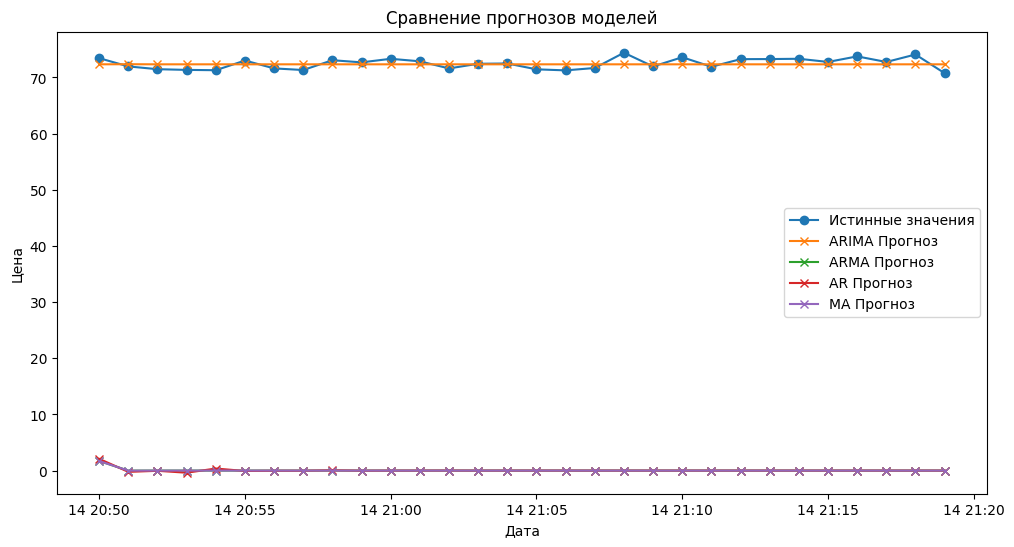

In [29]:
# Шаг 4: Прогнозирование на 30 дней вперед
forecast_horizon = 30

# Прогноз ARIMA
arima_forecast = arima_model.forecast(steps=forecast_horizon)

# Прогноз ARMA
arma_forecast = arma_model.forecast(steps=forecast_horizon)

# Прогноз AR
ar_forecast = ar_model.forecast(steps=forecast_horizon)

# Прогноз MA
ma_forecast = ma_model.forecast(steps=forecast_horizon)

# Шаг 5: Оценка качества прогнозов (MAE, RMSE, MAPE)
def evaluate_forecast(true_values, predicted_values):
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    mape = mean_absolute_percentage_error(true_values, predicted_values)
    return mae, rmse, mape

# Для сравнения: возьмем последние 30 значений истинного ряда
true_values = ts[-forecast_horizon:]

# Оценка моделей
ar_metrics = evaluate_forecast(true_values, ar_forecast)
ma_metrics = evaluate_forecast(true_values, ma_forecast)
arma_metrics = evaluate_forecast(true_values, arma_forecast)
arima_metrics = evaluate_forecast(true_values, arima_forecast)

print(f"AR Metrics: MAE={ar_metrics[0]:.3f}, RMSE={ar_metrics[1]:.3f}, MAPE={ar_metrics[2]:.3f}")
print(f"MA Metrics: MAE={ma_metrics[0]:.3f}, RMSE={ma_metrics[1]:.3f}, MAPE={ma_metrics[2]:.3f}")
print(f"ARMA Metrics: MAE={arma_metrics[0]:.3f}, RMSE={arma_metrics[1]:.3f}, MAPE={arma_metrics[2]:.3f}")
print(f"ARIMA Metrics: MAE={arima_metrics[0]:.3f}, RMSE={arima_metrics[1]:.3f}, MAPE={arima_metrics[2]:.3f}")

# Шаг 6: Визуализация результатов прогнозирования
plt.figure(figsize=(12, 6))
plt.plot(true_values.index, true_values, label='Истинные значения', marker='o')
plt.plot(true_values.index, arima_forecast, label='ARIMA Прогноз', marker='x')
plt.plot(true_values.index, arma_forecast, label='ARMA Прогноз', marker='x')
plt.plot(true_values.index, ar_forecast, label='AR Прогноз', marker='x')
plt.plot(true_values.index, ma_forecast, label='MA Прогноз', marker='x')
plt.title('Сравнение прогнозов моделей')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()